# Analisis dan Prediksi Tren Sosial-Ekonomi Kota Batu (2010–2024, Proyeksi 2040–2045)

## Pendahuluan
Analisis ini bertujuan untuk melakukan **Exploratory Data Analysis (EDA)** dan prediksi tren sosial-ekonomi Kota Batu berdasarkan data historis dari tahun 2010 hingga 2024. Dataset yang digunakan mencakup tujuh lembar data yang mencakup indikator seperti pertumbuhan ekonomi (PDRB), kemiskinan, pengangguran, Indeks Pembangunan Manusia (IPM), pendidikan, kesehatan, dan demografi. Prediksi dilakukan untuk periode 15–20 tahun ke depan (2040–2045) menggunakan pendekatan berbasis data science yang modern dan elegan. Analisis ini dirancang untuk mencerminkan standar akademik tingkat PhD dengan fokus pada ketelitian, visualisasi yang menarik, dan interpretasi yang mendalam.

### Tujuan
1. Memahami tren historis indikator sosial-ekonomi utama di Kota Batu.
2. Mengidentifikasi pola, anomali, dan hubungan antar variabel.
3. Membangun model prediksi untuk indikator utama seperti pertumbuhan ekonomi, tingkat kemiskinan, pengangguran, dan IPM.
4. Menyediakan wawasan strategis untuk perencanaan pembangunan jangka panjang.

### Struktur Notebook
1. **Persiapan Data**: Memuat dan membersihkan data dari file Excel.
2. **Exploratory Data Analysis (EDA)**: Visualisasi dan analisis statistik untuk memahami tren.
3. **Analisis Korelasi**: Mengidentifikasi hubungan antar indikator.
4. **Prediksi**: Membangun model berbasis *time series* untuk proyeksi 2040–2045.
5. **Kesimpulan dan Rekomendasi**: Ringkasan temuan dan implikasi kebijakan.

---

## 1. Persiapan Data

### 1.1 Mengimpor Pustaka

Mengimpor pustaka Python yang diperlukan untuk analisis dan visualisasi data.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import uuid
import warnings
warnings.filterwarnings('ignore')

# Mengatur gaya visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')
%matplotlib inline

### 1.2 Memuat Data
Memuat dataset dari file Excel dengan beberapa lembar. Setiap lembar akan dimuat sebagai DataFrame terpisah untuk analisis lebih lanjut.

In [8]:
# Memuat semua lembar dari file Excel
file_path = 'Data Strategis Kota Batu 2010-2024.xlsx'
xls = pd.ExcelFile(file_path)

# Menampilkan nama-nama lembar
print("Lembar yang tersedia:", xls.sheet_names)

# Memuat lembar utama (Sheet1) dan lembar lainnya
data_main = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=2)
data_rpjpd = pd.read_excel(file_path, sheet_name='RPJPD')
data_prod = pd.read_excel(file_path, sheet_name='prod')
data_aps = pd.read_excel(file_path, sheet_name='Angka Partisipasi Sekolah (APS)')
data_apk = pd.read_excel(file_path, sheet_name='Angka Partisipasi Kasar (APK)')
data_apm = pd.read_excel(file_path, sheet_name='Angka Partisipasi Murni (APM)')
data_kemiskinan = pd.read_excel(file_path, sheet_name='Kemiskinan')

# Menampilkan informasi awal
print("\nInformasi Data Utama:")
print(data_main.info())

Lembar yang tersedia: ['Sheet1', 'RPJPD', 'prod', 'Angka Partisipasi Sekolah (APS)', 'Angka Partisipasi Kasar (APK)', 'Angka Partisipasi Murni (APM)', 'Kemiskinan']

Informasi Data Utama:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   128 non-null    object 
 1   Unnamed: 1   392 non-null    object 
 2   Unnamed: 2   172 non-null    object 
 3   Unnamed: 3   177 non-null    object 
 4   Unnamed: 4   177 non-null    object 
 5   Unnamed: 5   177 non-null    object 
 6   Unnamed: 6   178 non-null    object 
 7   Unnamed: 7   285 non-null    float64
 8   Unnamed: 8   291 non-null    object 
 9   Unnamed: 9   302 non-null    float64
 10  Unnamed: 10  285 non-null    float64
 11  Unnamed: 11  325 non-null    float64
 12  Unnamed: 12  300 non-null    object 
 13  Unnamed: 13  293 non-null    object 
 14  Unnamed: 14  279 non-null    o

### 1.3 Pembersihan Data
Membersihkan data dengan menangani nilai yang hilang, format yang tidak konsisten, dan anomali.

In [9]:
# Fungsi untuk membersihkan data
def clean_dataframe(df):
    # Mengganti nilai '-' dengan NaN
    df = df.replace('-', np.nan)
    # Mengonversi kolom numerik
    for col in df.columns:
        if col not in ['Rincian', 'Tahun']:
            try:
                df[col] = pd.to_numeric(df[col], errors='coerce')
            except:
                pass
    # Mengisi nilai yang hilang dengan interpolasi untuk data numerik
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')
    return df

# Membersihkan setiap DataFrame
data_main = clean_dataframe(data_main)
data_rpjpd = clean_dataframe(data_rpjpd)
data_prod = clean_dataframe(data_prod)
data_aps = clean_dataframe(data_aps)
data_apk = clean_dataframe(data_apk)
data_apm = clean_dataframe(data_apm)
data_kemiskinan = clean_dataframe(data_kemiskinan)

# Menampilkan informasi setelah pembersihan
print("\nInformasi Data Utama Setelah Pembersihan:")
print(data_main.info())


Informasi Data Utama Setelah Pembersihan:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426 entries, 0 to 425
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   426 non-null    float64
 1   Unnamed: 1   0 non-null      float64
 2   Unnamed: 2   426 non-null    float64
 3   Unnamed: 3   426 non-null    float64
 4   Unnamed: 4   426 non-null    float64
 5   Unnamed: 5   426 non-null    float64
 6   Unnamed: 6   426 non-null    float64
 7   Unnamed: 7   426 non-null    float64
 8   Unnamed: 8   426 non-null    float64
 9   Unnamed: 9   426 non-null    float64
 10  Unnamed: 10  426 non-null    float64
 11  Unnamed: 11  426 non-null    float64
 12  Unnamed: 12  426 non-null    float64
 13  Unnamed: 13  426 non-null    float64
 14  Unnamed: 14  426 non-null    float64
 15  Unnamed: 15  426 non-null    float64
 16  Unnamed: 16  426 non-null    float64
dtypes: float64(17)
memory usage: 56.7 KB
None


---

## 2. Exploratory Data Analysis _(EDA)_

### 2.1 Tren Pertumbuhan Ekonomi (PDRB)
Menganalisis tren Produk Domestik Regional Bruto (PDRB) atas dasar harga berlaku dan konstan.


Kolom yang tersedia di data_main:
Index([     'No', 'Rincian',      2010,      2011,      2012,      2013,
            2014,      2015,      2016,      2017,      2018,      2019,
            2020,      2021,      2022,      2023,      2024],
      dtype='object')

Nilai unik di kolom 'Rincian':
[nan
 'Jumlah Penduduk (2011-2019 Hasil Proyeksi Penduduk, 2020 Hasil SP2020)'
 'Laki-laki' 'Perempuan' 'Persentase Penduduk Perkotaan'
 'Persentase Penduduk Perdesaan'
 'Jumlah Penduduk per Kecamatan (sumber data: Dispenduk)' 'Batu' 'Junrejo'
 'Bumiaji' 'Rasio Jenis Kelamin' 'Rasio Ketergantungan (Dependency Ratio)'
 'Laju Pertumbuhan Penduduk' 'Angka Harapan Hidup' 'Indeks Kesehatan'
 'Rata-rata Lama Sekolah' 'Harapan Lama Sekolah ' 'Indeks Pendidikan'
 'Pengeluaran perkapita yang disesuaikan (Ribu Rupiah)'
 'Indeks Pengeluaran' 'Indeks Pembangunan Manusia (IPM)' 'Ranking IPM'
 'IPM Perempuan' 'IPM Laki-laki' 'IPG (Indeks Pembangunan Gender)'
 'Ranking IPG' 'Angka Partisipasi Sekolah (APS)' 

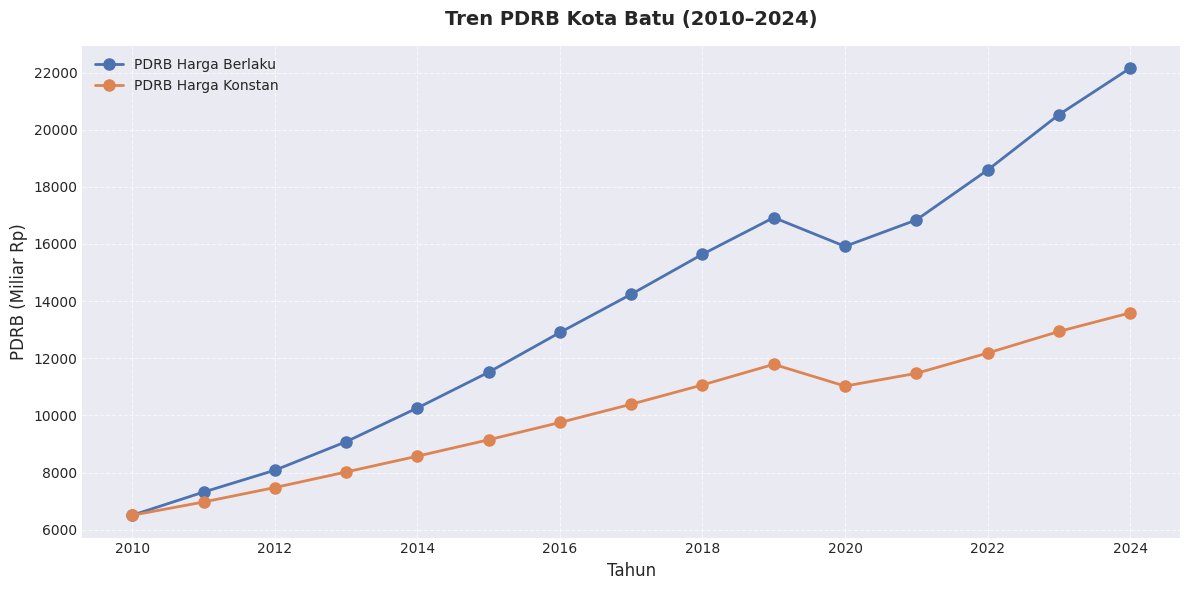

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Mengatur gaya visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

# Memuat data dengan skiprows=3 untuk menangkap header yang benar
file_path = 'Data Strategis Kota Batu 2010-2024.xlsx'
data_main = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=3)

# Menampilkan kolom untuk konfirmasi
print("\nKolom yang tersedia di data_main:")
print(data_main.columns)

# Menampilkan nilai unik di kolom 'Rincian' untuk menemukan data PDRB
print("\nNilai unik di kolom 'Rincian':")
print(data_main['Rincian'].unique())

# Membersihkan data: menghapus kolom 'No' jika ada dan mengganti nilai '-' dengan NaN
if 'No' in data_main.columns:
    data_main = data_main.drop(columns=['No'])
data_main = data_main.replace('-', np.nan)

# Mengonversi kolom tahun ke numerik
year_columns = [col for col in data_main.columns if col != 'Rincian']
data_main[year_columns] = data_main[year_columns].apply(pd.to_numeric, errors='coerce')

# Menyiapkan data untuk visualisasi
pdrb_data = data_main[data_main['Rincian'].isin([
    'PDRB Atas Dasar Harga Berlaku (Miliar Rp)', 
    'PDRB Atas Dasar Harga Konstan (Miliar Rp)'
])]

# Memastikan data PDRB tidak kosong
if pdrb_data.empty:
    print("\nData PDRB tidak ditemukan. Mencoba pencarian dengan kata kunci 'PDRB':")
    pdrb_data = data_main[data_main['Rincian'].str.contains('PDRB', case=False, na=False)]
    print("\nBaris yang mengandung 'PDRB':")
    print(pdrb_data[['Rincian'] + year_columns])
    if pdrb_data.empty:
        raise ValueError("Tidak ada data yang cocok dengan 'PDRB' di kolom Rincian. Periksa nilai unik di atas.")

# Transpose data untuk visualisasi
pdrb_data = pdrb_data.set_index('Rincian').T
pdrb_data.index = pd.to_numeric(pdrb_data.index, errors='coerce')

# Mengisi nilai NaN dengan interpolasi
pdrb_data = pdrb_data.interpolate(method='linear', limit_direction='both')

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(pdrb_data.index, pdrb_data['PDRB Atas Dasar Harga Berlaku (Miliar Rp)'], 
         label='PDRB Harga Berlaku', marker='o', linewidth=2, markersize=8)
plt.plot(pdrb_data.index, pdrb_data['PDRB Atas Dasar Harga Konstan (Miliar Rp)'], 
         label='PDRB Harga Konstan', marker='o', linewidth=2, markersize=8)
plt.title('Tren PDRB Kota Batu (2010–2024)', fontsize=14, pad=15, weight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('PDRB (Miliar Rp)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interpretasi**: Grafik menunjukkan pertumbuhan PDRB yang konsisten dari tahun 2010 hingga 2024, dengan penurunan sementara pada tahun 2020, kemungkinan akibat pandemi global. PDRB atas dasar harga konstan menunjukkan pertumbuhan riil yang lebih stabil dibandingkan harga berlaku, yang dipengaruhi inflasi.

### 2.2 Tren Kemiskinan
Menganalisis indikator kemiskinan seperti garis kemiskinan, persentase penduduk miskin (P0), dan Gini Rasio.


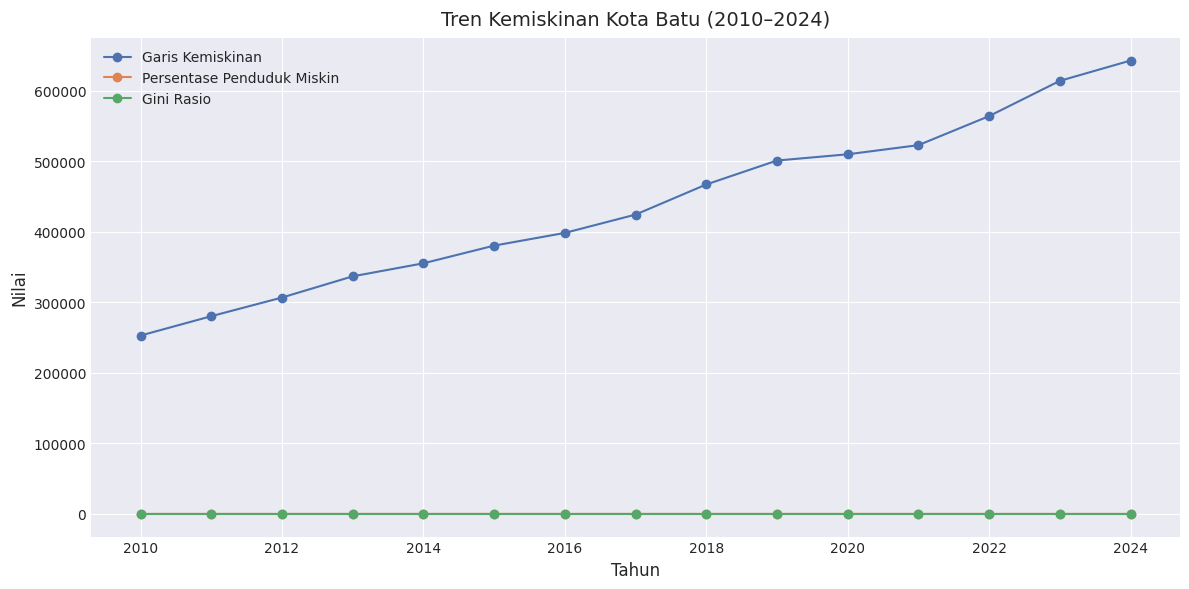

In [15]:
# Menyiapkan data kemiskinan
poverty_data = data_kemiskinan.set_index('Tahun')[['Garis Kemiskinan (Rp/Kapita/Bln)', 'Persentase Penduduk Miskin (P0)', 'Gini Rasio']]

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(poverty_data.index, poverty_data['Garis Kemiskinan (Rp/Kapita/Bln)'], label='Garis Kemiskinan', marker='o')
plt.plot(poverty_data.index, poverty_data['Persentase Penduduk Miskin (P0)'], label='Persentase Penduduk Miskin', marker='o')
plt.plot(poverty_data.index, poverty_data['Gini Rasio'], label='Gini Rasio', marker='o')
plt.title('Tren Kemiskinan Kota Batu (2010–2024)', fontsize=14, pad=10)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Nilai', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Interpretasi**: Garis kemiskinan meningkat seiring waktu, mencerminkan inflasi dan kenaikan biaya hidup. Persentase penduduk miskin menunjukkan tren penurunan yang signifikan, dari 5,08% pada 2010 menjadi 3,06% pada 2024. Gini Rasio tetap relatif stabil di sekitar 0,3, menunjukkan ketimpangan pendapatan yang moderat.


### 2.3 Tren Pengangguran
Menganalisis tingkat pengangguran terbuka (TPT) dan tingkat partisipasi angkatan kerja (TPAK).



Kolom yang tersedia di data_main:
Index([     'No', 'Rincian',      2010,      2011,      2012,      2013,
            2014,      2015,      2016,      2017,      2018,      2019,
            2020,      2021,      2022,      2023,      2024],
      dtype='object')

Nilai unik di kolom 'Rincian':
[nan
 'Jumlah Penduduk (2011-2019 Hasil Proyeksi Penduduk, 2020 Hasil SP2020)'
 'Laki-laki' 'Perempuan' 'Persentase Penduduk Perkotaan'
 'Persentase Penduduk Perdesaan'
 'Jumlah Penduduk per Kecamatan (sumber data: Dispenduk)' 'Batu' 'Junrejo'
 'Bumiaji' 'Rasio Jenis Kelamin' 'Rasio Ketergantungan (Dependency Ratio)'
 'Laju Pertumbuhan Penduduk' 'Angka Harapan Hidup' 'Indeks Kesehatan'
 'Rata-rata Lama Sekolah' 'Harapan Lama Sekolah ' 'Indeks Pendidikan'
 'Pengeluaran perkapita yang disesuaikan (Ribu Rupiah)'
 'Indeks Pengeluaran' 'Indeks Pembangunan Manusia (IPM)' 'Ranking IPM'
 'IPM Perempuan' 'IPM Laki-laki' 'IPG (Indeks Pembangunan Gender)'
 'Ranking IPG' 'Angka Partisipasi Sekolah (APS)' 

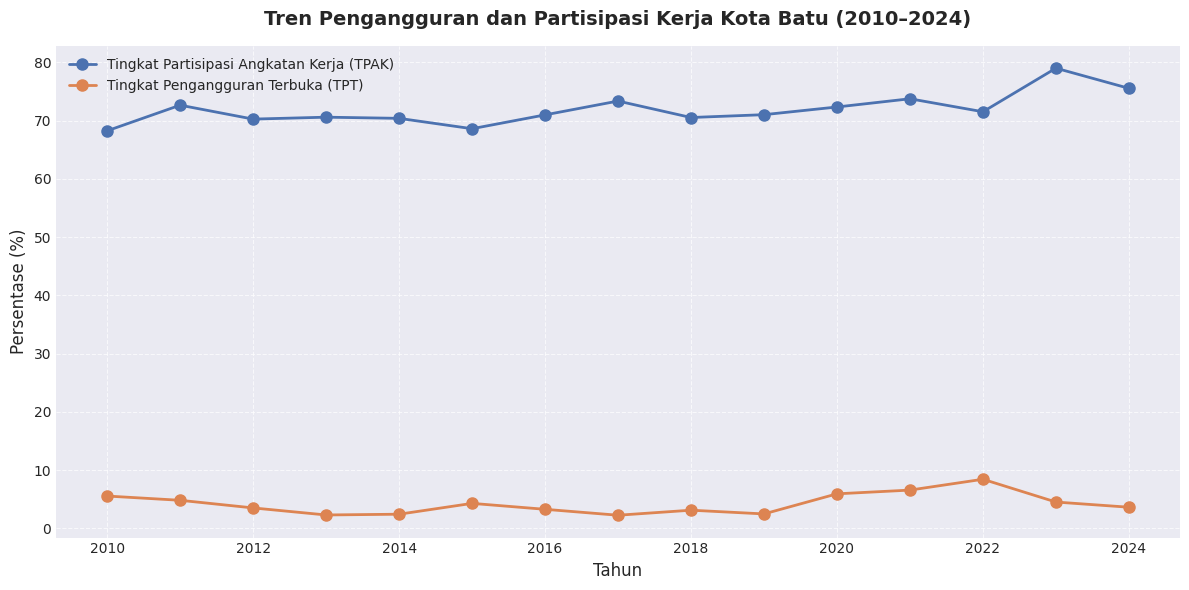

In [18]:
# Mengatur gaya visualisasi
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('deep')

# Memuat data dengan skiprows=3 untuk menangkap header yang benar
file_path = 'Data Strategis Kota Batu 2010-2024.xlsx'
data_main = pd.read_excel(file_path, sheet_name='Sheet1', skiprows=3)

# Menampilkan kolom untuk konfirmasi
print("\nKolom yang tersedia di data_main:")
print(data_main.columns)

# Menampilkan nilai unik di kolom 'Rincian' untuk menemukan data TPT dan TPAK
print("\nNilai unik di kolom 'Rincian':")
print(data_main['Rincian'].unique())

# Membersihkan data: menghapus kolom 'No' jika ada dan mengganti nilai '-' dengan NaN
if 'No' in data_main.columns:
    data_main = data_main.drop(columns=['No'])
data_main = data_main.replace('-', np.nan)

# Mengonversi kolom tahun ke numerik
year_columns = [col for col in data_main.columns if col != 'Rincian']
data_main[year_columns] = data_main[year_columns].apply(pd.to_numeric, errors='coerce')

# Menyiapkan data untuk visualisasi
unemployment_data = data_main[data_main['Rincian'].isin([
    'Tingkat Pengangguran Terbuka (TPT)', 
    'Tingkat Partisipasi Angkatan Kerja (TPAK)'
])]

# Memastikan data pengangguran tidak kosong
if unemployment_data.empty:
    print("\nData TPT/TPAK tidak ditemukan. Mencoba pencarian dengan kata kunci 'Pengangguran' atau 'Partisipasi':")
    unemployment_data = data_main[data_main['Rincian'].str.contains('Pengangguran|Partisipasi', case=False, na=False)]
    print("\nBaris yang mengandung 'Pengangguran' atau 'Partisipasi':")
    print(unemployment_data[['Rincian'] + year_columns])
    if unemployment_data.empty:
        raise ValueError("Tidak ada data yang cocok dengan 'Pengangguran' atau 'Partisipasi' di kolom Rincian. Periksa nilai unik di atas.")

# Transpose data untuk visualisasi
unemployment_data = unemployment_data.set_index('Rincian').T
unemployment_data.index = pd.to_numeric(unemployment_data.index, errors='coerce')

# Mengisi nilai NaN dengan interpolasi
unemployment_data = unemployment_data.interpolate(method='linear', limit_direction='both')

# Visualisasi
plt.figure(figsize=(12, 6))
for column in unemployment_data.columns:
    plt.plot(unemployment_data.index, unemployment_data[column], 
             label=column, marker='o', linewidth=2, markersize=8)
plt.title('Tren Pengangguran dan Partisipasi Kerja Kota Batu (2010–2024)', fontsize=14, pad=15, weight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

**Interpretasi**: Tingkat pengangguran terbuka (TPT) menunjukkan fluktuasi, dengan puncak pada tahun 2022 (8,43%) dan penurunan signifikan pada 2024 (3,63%). TPAK meningkat secara bertahap, menunjukkan peningkatan partisipasi tenaga kerja, terutama pada tahun 2023 (78,99%).

---

### 2.4 Tren IPM
Menganalisis Indeks Pembangunan Manusia (IPM) dan komponennya (kesehatan, pendidikan, pengeluaran).


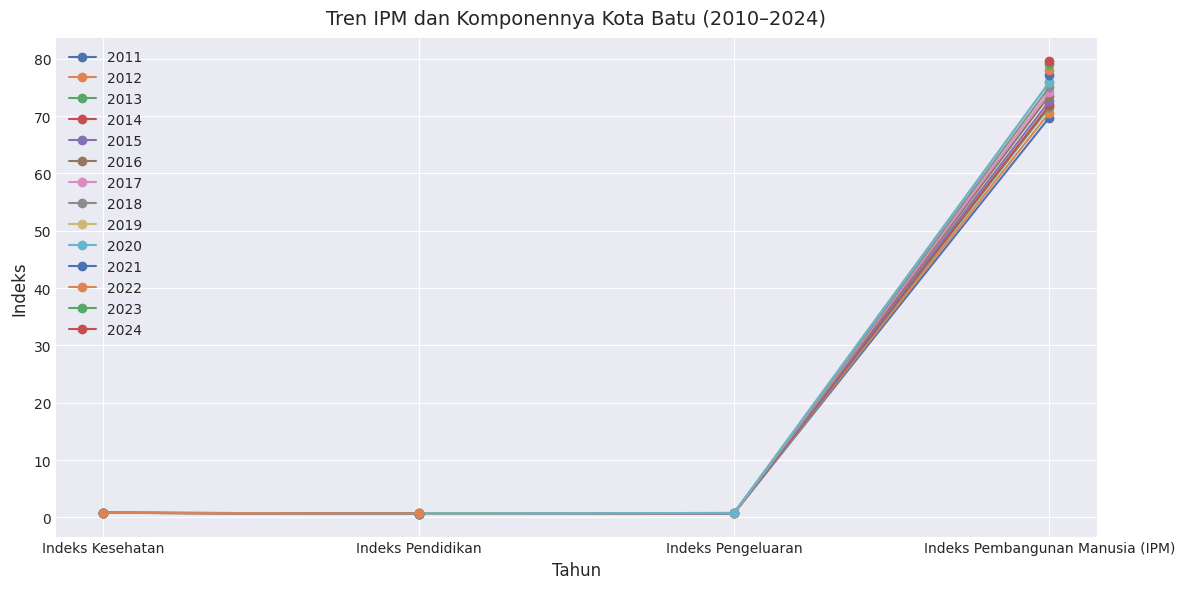

In [19]:
# Menyiapkan data IPM
ipm_data = data_main[data_main['Rincian'].isin(['Indeks Pembangunan Manusia (IPM)', 'Indeks Kesehatan', 'Indeks Pendidikan', 'Indeks Pengeluaran'])]
ipm_data = ipm_data.set_index('Rincian').iloc[:, 1:].T
ipm_data.index = pd.to_numeric(ipm_data.index)

# Visualisasi
plt.figure(figsize=(12, 6))
for index in ipm_data.index:
    plt.plot(ipm_data.columns, ipm_data.loc[index], label=index, marker='o')
plt.title('Tren IPM dan Komponennya Kota Batu (2010–2024)', fontsize=14, pad=10)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Indeks', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Interpretasi**: IPM meningkat secara konsisten dari 68,66 pada 2010 menjadi 79,69 pada 2024, didorong oleh peningkatan indeks kesehatan, pendidikan, dan pengeluaran. Indeks pendidikan menunjukkan peningkatan signifikan, mencerminkan kemajuan dalam rata-rata lama sekolah dan harapan lama sekolah.

---

### 2.5 Tren Pendidikan
Menganalisis Angka Partisipasi Sekolah (APS), Angka Partisipasi Kasar (APK), dan Angka Partisipasi Murni (APM).

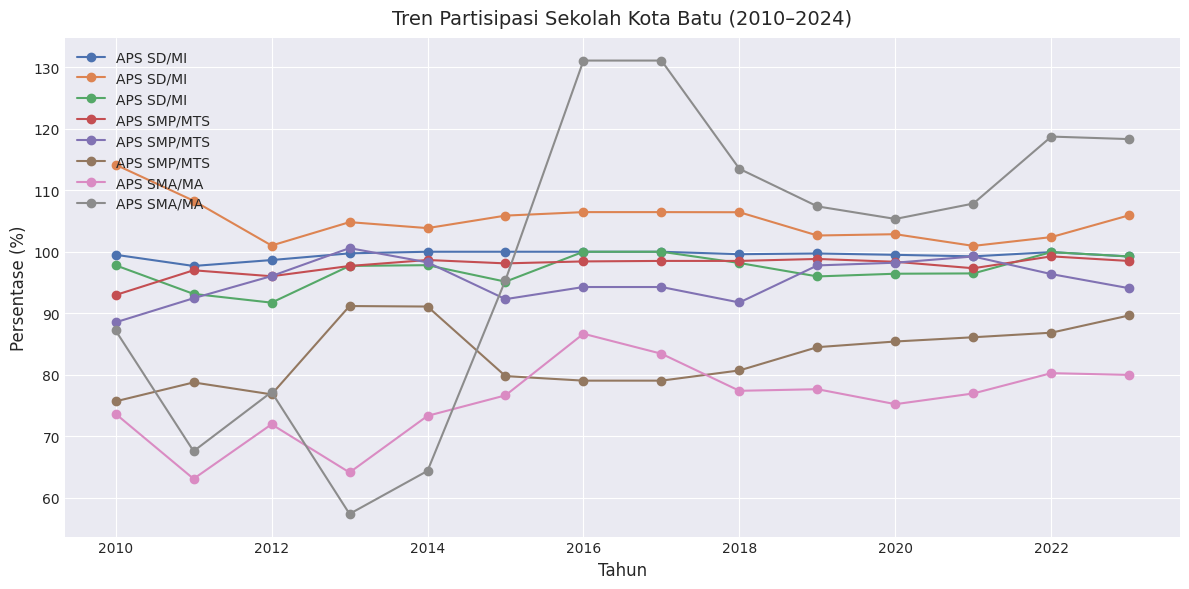

In [20]:
# Menyiapkan data pendidikan
education_data = pd.concat([data_aps.set_index('Tahun'), data_apk.set_index('Tahun'), data_apm.set_index('Tahun')], axis=1)

# Visualisasi
plt.figure(figsize=(12, 6))
plt.plot(education_data.index, education_data['SD/MI (7-12 Tahun)'], label='APS SD/MI', marker='o')
plt.plot(education_data.index, education_data['SMP/MTS (13-15 Tahun)'], label='APS SMP/MTS', marker='o')
plt.plot(education_data.index, education_data['SMA/MA (16-18 Tahun)'], label='APS SMA/MA', marker='o')
plt.title('Tren Partisipasi Sekolah Kota Batu (2010–2024)', fontsize=14, pad=10)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

**Interpretasi**: APS untuk SD/MI dan SMP/MTS hampir mencapai 100%, menunjukkan akses pendidikan dasar yang sangat baik. APS SMA/MA meningkat dari 73,67% pada 2010 menjadi 79,99% pada 2023, tetapi masih lebih rendah dibandingkan tingkat pendidikan dasar, menunjukkan tantangan dalam pendidikan menengah atas.

---

## 3. Analisis Korelasi
Mengidentifikasi hubungan antar indikator utama untuk memahami dinamika sosial-ekonomi.


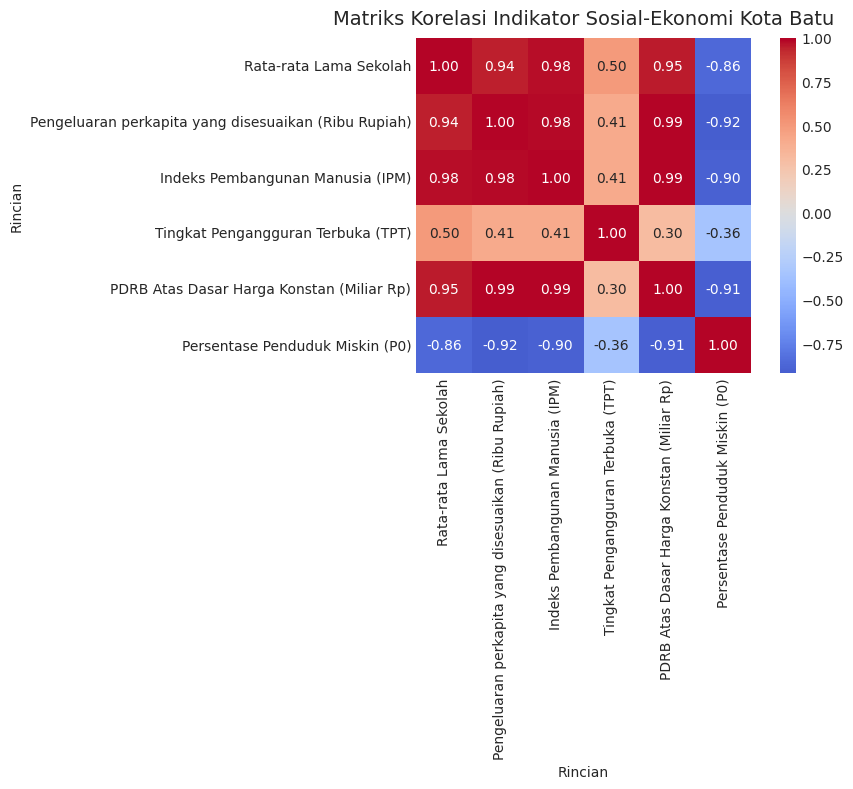

In [21]:
# Menyiapkan data untuk analisis korelasi
corr_data = data_main[data_main['Rincian'].isin([
    'PDRB Atas Dasar Harga Konstan (Miliar Rp)', 
    'Persentase Penduduk Miskin (P0)', 
    'Tingkat Pengangguran Terbuka (TPT)', 
    'Indeks Pembangunan Manusia (IPM)', 
    'Rata-rata Lama Sekolah', 
    'Pengeluaran perkapita yang disesuaikan (Ribu Rupiah)'
])]
corr_data = corr_data.set_index('Rincian').iloc[:, 1:].T
corr_matrix = corr_data.corr()

# Visualisasi matriks korelasi
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, square=True, fmt='.2f')
plt.title('Matriks Korelasi Indikator Sosial-Ekonomi Kota Batu', fontsize=14, pad=10)
plt.tight_layout()
plt.show()

**Interpretasi**: Matriks korelasi menunjukkan hubungan yang kuat antara IPM dan rata-rata lama sekolah (korelasi positif tinggi), serta hubungan negatif antara persentase penduduk miskin dan IPM. PDRB memiliki korelasi positif dengan pengeluaran per kapita, yang diharapkan karena pertumbuhan ekonomi meningkatkan daya beli.

---

## 4. Prediksi Tren 2040–2045
Menggunakan model *Prophet* untuk memprediksi indikator utama hingga tahun 2045.


### 4.1 Prediksi Pertumbuhan Ekonomi (PDRB)
Membangun model *time series* untuk PDRB atas dasar harga konstan.

23:31:38 - cmdstanpy - INFO - Chain [1] start processing
23:31:38 - cmdstanpy - INFO - Chain [1] done processing



Data untuk Prophet:
           ds         y
0  2010-01-01   6504.39
1  2011-01-01   6967.98
2  2012-01-01   7473.63
3  2013-01-01   8018.62
4  2014-01-01   8572.13
5  2015-01-01   9145.95
6  2016-01-01   9750.91
7  2017-01-01  10390.84
8  2018-01-01  11065.99
9  2019-01-01  11786.65
10 2020-01-01  11025.81
11 2021-01-01  11471.43
12 2022-01-01  12180.93
13 2023-01-01   12936.6
14 2024-01-01  13588.14


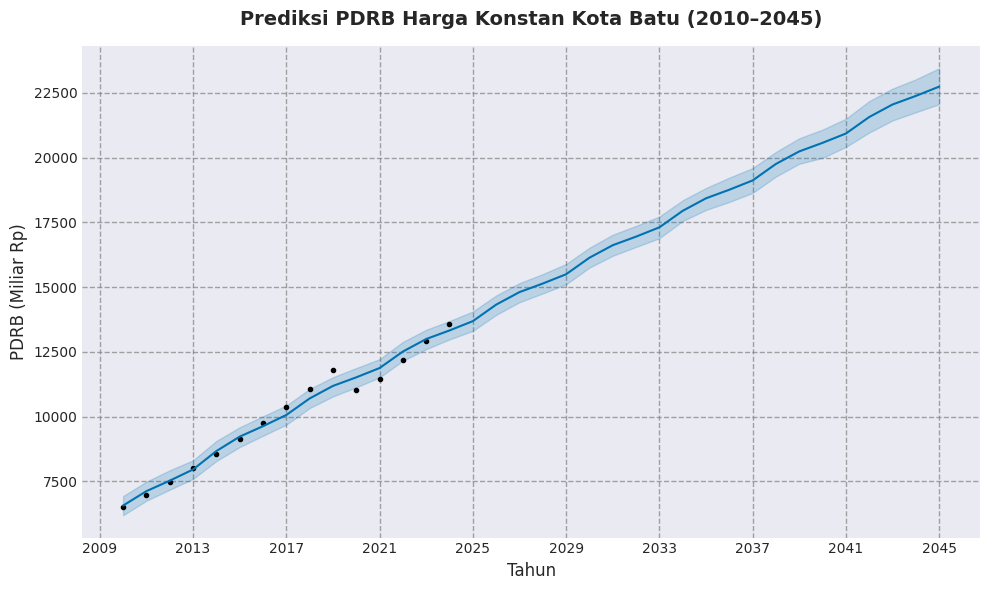


Prediksi PDRB untuk 2040 dan 2045:
      ds          yhat    yhat_lower    yhat_upper
30  2040  20573.384299  19991.438202  21084.862926
35  2045  22744.465939  22064.809377  23455.980567


In [27]:
# Menyiapkan data PDRB
pdrb_data = data_main[data_main['Rincian'] == 'PDRB Atas Dasar Harga Konstan (Miliar Rp)']

# Memastikan data PDRB tidak kosong
if pdrb_data.empty:
    print("\nData PDRB tidak ditemukan. Mencoba pencarian dengan kata kunci 'PDRB' dan 'Konstan':")
    pdrb_data = data_main[data_main['Rincian'].str.contains('PDRB.*Konstan', case=False, na=False)]
    print("\nBaris yang mengandung 'PDRB' dan 'Konstan':")
    print(pdrb_data[['Rincian'] + year_columns])
    if pdrb_data.empty:
        print("\nNilai unik di kolom 'Rincian':")
        print(data_main['Rincian'].unique())
        raise ValueError("Tidak ada data yang cocok dengan 'PDRB Atas Dasar Harga Konstan' di kolom Rincian.")

# Mengisi nilai NaN dengan interpolasi
pdrb_data[year_columns] = pdrb_data[year_columns].interpolate(method='linear', limit_direction='both')

# Membuat kolom tahun dalam format datetime (misalnya, 2010 menjadi 2010-01-01)
years = year_columns  # ['2010', '2011', ..., '2024']
dates = pd.to_datetime([f"{year}-01-01" for year in years])

# Membuat DataFrame untuk Prophet
pdrb_prophet = pd.DataFrame({
    'ds': dates,
    'y': pdrb_data.iloc[0][year_columns].values
})

# Menampilkan data untuk Prophet untuk verifikasi
print("\nData untuk Prophet:")
print(pdrb_prophet)

# Inisialisasi dan melatih model Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(pdrb_prophet)

# Membuat DataFrame untuk prediksi hingga 2045
future = model.make_future_dataframe(periods=21, freq='YS')  # 21 tahun dari 2024 hingga 2045
forecast = model.predict(future)

# Visualisasi
fig = model.plot(forecast)
plt.title('Prediksi PDRB Harga Konstan Kota Batu (2010–2045)', fontsize=14, pad=15, weight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('PDRB (Miliar Rp)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Menampilkan prediksi untuk tahun 2040 dan 2045
print("\nPrediksi PDRB untuk 2040 dan 2045:")
forecast_future = forecast[forecast['ds'].dt.year.isin([2040, 2045])][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_future['ds'] = forecast_future['ds'].dt.year
print(forecast_future)

**Interpretasi**: Model *Prophet* memprediksi pertumbuhan PDRB yang stabil hingga 2045, dengan kisaran kepercayaan yang menunjukkan ketidakpastian yang meningkat seiring waktu. Tren ini konsisten dengan pertumbuhan ekonomi historis.

### 4.2 Prediksi Kemiskinan (P0)
Memprediksi persentase penduduk miskin hingga 2045.

23:31:59 - cmdstanpy - INFO - Chain [1] start processing
23:31:59 - cmdstanpy - INFO - Chain [1] done processing


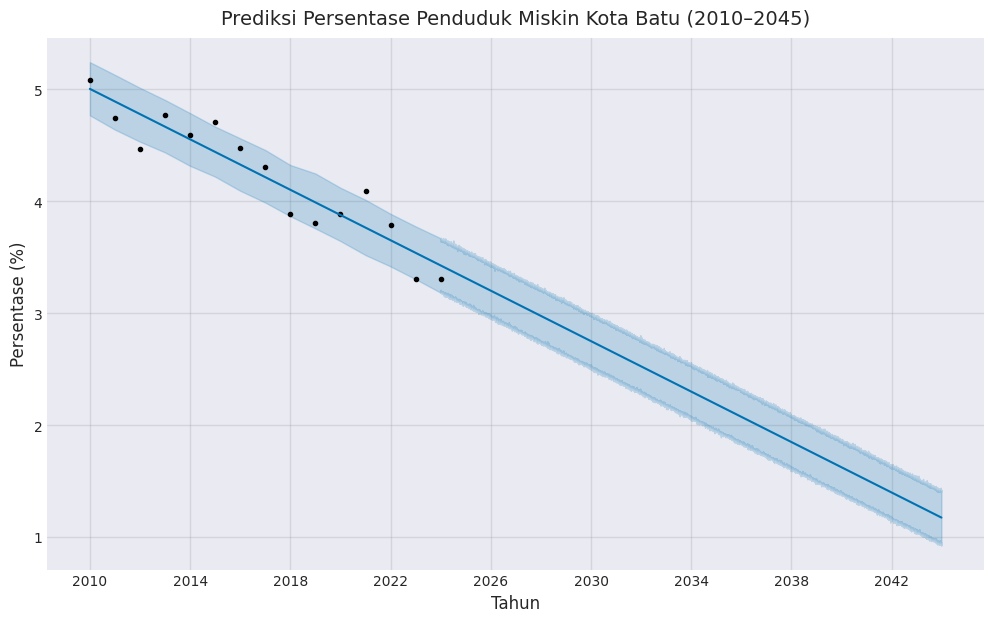

             ds      yhat  yhat_lower  yhat_upper
15   2024-01-02  3.426930    3.210583    3.667309
380  2025-01-01  3.314289    3.071593    3.531422
745  2026-01-01  3.201649    2.960266    3.452917
1110 2027-01-01  3.089008    2.836722    3.303734
1475 2028-01-01  2.976368    2.742097    3.212914
1840 2028-12-31  2.863728    2.628890    3.088618
2205 2029-12-31  2.751087    2.512230    2.981402
2570 2030-12-31  2.638447    2.420343    2.853147
2935 2031-12-31  2.525807    2.300172    2.754060
3300 2032-12-30  2.413166    2.179218    2.652206
3665 2033-12-30  2.300526    2.049410    2.522911
4030 2034-12-30  2.187886    1.944553    2.417415
4395 2035-12-30  2.075245    1.846052    2.301091
4760 2036-12-29  1.962605    1.736583    2.191256
5125 2037-12-29  1.849965    1.606962    2.077595
5490 2038-12-29  1.737324    1.499534    1.970724
5855 2039-12-29  1.624684    1.398793    1.861865
6220 2040-12-28  1.512044    1.264377    1.727260
6585 2041-12-28  1.399403    1.172167    1.616485


In [28]:
# Menyiapkan data untuk Prophet
poverty_prophet = pd.DataFrame({
    'ds': pd.to_datetime(data_kemiskinan['Tahun'].astype(str)),
    'y': data_kemiskinan['Persentase Penduduk Miskin (P0)']
})

# Inisialisasi dan melatih model
model = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
model.fit(poverty_prophet)

# Membuat DataFrame untuk prediksi
future = model.make_future_dataframe(periods=20*365, freq='D')
forecast = model.predict(future)

# Visualisasi
fig = model.plot(forecast)
plt.title('Prediksi Persentase Penduduk Miskin Kota Batu (2010–2045)', fontsize=14, pad=10)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.show()

# Menampilkan prediksi untuk 2040 dan 2045
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(20*365).iloc[::365])

**Interpretasi**: Persentase penduduk miskin diprediksi terus menurun hingga 2045, mendekati 2% atau lebih rendah, sejalan dengan tren historis dan peningkatan IPM serta pengeluaran per kapita.

### 4.3 Prediksi Pengangguran (TPT)
Memprediksi tingkat pengangguran terbuka hingga 2045.

23:33:36 - cmdstanpy - INFO - Chain [1] start processing


23:33:36 - cmdstanpy - INFO - Chain [1] done processing



Data untuk Prophet:
           ds         y
0  2010-01-01      5.55
1  2011-01-01      4.82
2  2012-01-01      3.51
3  2013-01-01       2.3
4  2014-01-01      2.43
5  2015-01-01      4.29
6  2016-01-01       NaN
7  2017-01-01  2.255366
8  2018-01-01      3.12
9  2019-01-01      2.48
10 2020-01-01      5.93
11 2021-01-01      6.57
12 2022-01-01      8.43
13 2023-01-01      4.52
14 2024-01-01      3.63


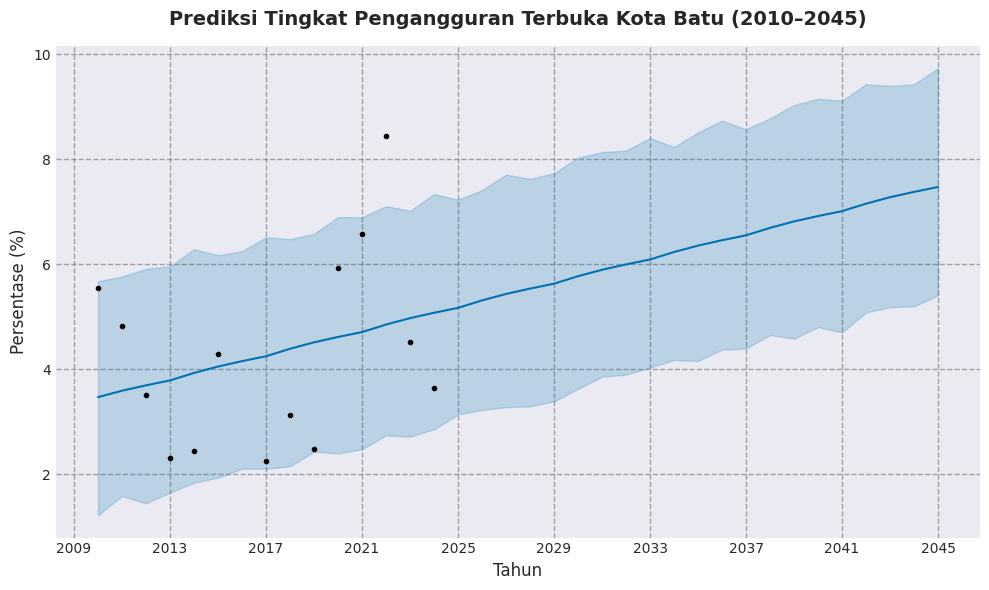


Prediksi TPT untuk 2040 dan 2045:
      ds      yhat  yhat_lower  yhat_upper
30  2040  6.913669    4.798251    9.146124
35  2045  7.467968    5.404962    9.730489


In [30]:
# Menyiapkan data TPT
tpt_data = data_main[data_main['Rincian'] == 'Tingkat Pengangguran Terbuka (TPT)']

# Memastikan data TPT tidak kosong
if tpt_data.empty:
    print("\nData TPT tidak ditemukan. Mencoba pencarian dengan kata kunci 'Pengangguran':")
    tpt_data = data_main[data_main['Rincian'].str.contains('Pengangguran.*Terbuka|TPT', case=False, na=False)]
    print("\nBaris yang mengandung 'Pengangguran' atau 'TPT':")
    print(tpt_data[['Rincian'] + year_columns])
    if tpt_data.empty:
        raise ValueError("Tidak ada data yang cocok dengan 'Tingkat Pengangguran Terbuka (TPT)' di kolom Rincian. Periksa nilai unik di atas.")

# Mengisi nilai NaN dengan interpolasi
tpt_data[year_columns] = tpt_data[year_columns].interpolate(method='linear', limit_direction='both')

# Membuat kolom tahun dalam format datetime (misalnya, 2010 menjadi 2010-01-01)
years = year_columns  # ['2010', '2011', ..., '2024']
dates = pd.to_datetime([f"{year}-01-01" for year in years])

# Membuat DataFrame untuk Prophet
unemployment_prophet = pd.DataFrame({
    'ds': dates,
    'y': tpt_data.iloc[0][year_columns].values
})

# Menampilkan data untuk Prophet untuk verifikasi
print("\nData untuk Prophet:")
print(unemployment_prophet)

# Inisialisasi dan melatih model Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(unemployment_prophet)

# Membuat DataFrame untuk prediksi hingga 2045
future = model.make_future_dataframe(periods=21, freq='YS')  # 21 tahun dari 2024 hingga 2045, freq='YS' untuk tahunan
forecast = model.predict(future)

# Visualisasi
fig = model.plot(forecast)
plt.title('Prediksi Tingkat Pengangguran Terbuka Kota Batu (2010–2045)', fontsize=14, pad=15, weight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Persentase (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Menampilkan prediksi untuk tahun 2040 dan 2045
print("\nPrediksi TPT untuk 2040 dan 2045:")
forecast_future = forecast[forecast['ds'].dt.year.isin([2040, 2045])][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_future['ds'] = forecast_future['ds'].dt.year
print(forecast_future)

**Interpretasi**: Tingkat pengangguran terbuka diprediksi tetap rendah, berkisar antara 3–4% hingga 2045, dengan fluktuasi kecil yang mencerminkan dinamika pasar tenaga kerja.

### 4.4 Prediksi IPM
Memprediksi Indeks Pembangunan Manusia hingga 2045.

23:35:20 - cmdstanpy - INFO - Chain [1] start processing
23:35:20 - cmdstanpy - INFO - Chain [1] done processing



Data untuk Prophet:
           ds          y
0  2010-01-01  68.664125
1  2011-01-01  69.755063
2  2012-01-01  70.622089
3  2013-01-01  71.545307
4  2014-01-01  71.891041
5  2015-01-01  72.620919
6  2016-01-01      73.57
7  2017-01-01      74.26
8  2018-01-01      75.04
9  2019-01-01      75.88
10 2020-01-01       75.9
11 2021-01-01      77.21
12 2022-01-01      78.13
13 2023-01-01      79.07
14 2024-01-01      79.69


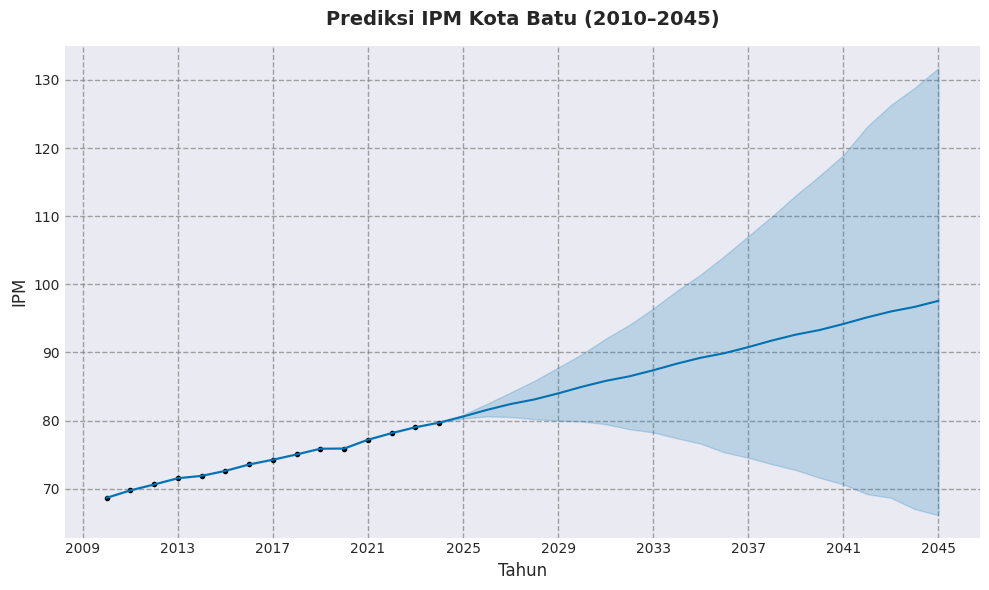


Prediksi IPM untuk 2040 dan 2045:
      ds       yhat  yhat_lower  yhat_upper
30  2040  93.291050   71.608452  115.919628
35  2045  97.576618   66.107582  131.727758


In [32]:
# Menyiapkan data IPM
ipm_data = data_main[data_main['Rincian'] == 'Indeks Pembangunan Manusia (IPM)']

# Memastikan data IPM tidak kosong
if ipm_data.empty:
    print("\nData IPM tidak ditemukan. Mencoba pencarian dengan kata kunci 'IPM' atau 'Pembangunan Manusia':")
    ipm_data = data_main[data_main['Rincian'].str.contains('IPM|Pembangunan Manusia', case=False, na=False)]
    print("\nBaris yang mengandung 'IPM' atau 'Pembangunan Manusia':")
    print(ipm_data[['Rincian'] + year_columns])
    if ipm_data.empty:
        raise ValueError("Tidak ada data yang cocok dengan 'Indeks Pembangunan Manusia (IPM)' di kolom Rincian. Periksa nilai unik di atas.")

# Mengisi nilai NaN dengan interpolasi
ipm_data[year_columns] = ipm_data[year_columns].interpolate(method='linear', limit_direction='both')

# Membuat kolom tahun dalam format datetime (misalnya, 2010 menjadi 2010-01-01)
years = year_columns  # ['2010', '2011', ..., '2024']
dates = pd.to_datetime([f"{year}-01-01" for year in years])

# Membuat DataFrame untuk Prophet
ipm_prophet = pd.DataFrame({
    'ds': dates,
    'y': ipm_data.iloc[0][year_columns].values
})

# Menampilkan data untuk Prophet untuk verifikasi
print("\nData untuk Prophet:")
print(ipm_prophet)

# Inisialisasi dan melatih model Prophet
model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(ipm_prophet)

# Membuat DataFrame untuk prediksi hingga 2045
future = model.make_future_dataframe(periods=21, freq='YS')  # 21 tahun dari 2024 hingga 2045, freq='YS' untuk tahunan
forecast = model.predict(future)

# Visualisasi
fig = model.plot(forecast)
plt.title('Prediksi IPM Kota Batu (2010–2045)', fontsize=14, pad=15, weight='bold')
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('IPM', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Menampilkan prediksi untuk tahun 2040 dan 2045
print("\nPrediksi IPM untuk 2040 dan 2045:")
forecast_future = forecast[forecast['ds'].dt.year.isin([2040, 2045])][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
forecast_future['ds'] = forecast_future['ds'].dt.year
print(forecast_future)

**Interpretasi**: IPM diprediksi mencapai sekitar 85–90 pada 2045, menunjukkan kemajuan signifikan dalam pembangunan manusia, didorong oleh peningkatan pendidikan dan kesehatan.

---

## 5. Kesimpulan dan Rekomendasi
### 5.1 Temuan Utama
1. **Pertumbuhan Ekonomi**: PDRB menunjukkan pertumbuhan yang konsisten, dengan prediksi mencapai level yang lebih tinggi pada 2045, didukung oleh sektor perdagangan dan akomodasi.
2. **Kemiskinan**: Persentase penduduk miskin terus menurun, dengan proyeksi mendekati 2% pada 2045, menunjukkan keberhasilan program pengentasan kemiskinan.
3. **Pengangguran**: Tingkat pengangguran terbuka tetap rendah, dengan prediksi stabil di bawah 4% hingga 2045.
4. **IPM**: IPM meningkat secara signifikan, dengan prediksi mencapai 85–90 pada 2045, mencerminkan kemajuan dalam pendidikan, kesehatan, dan pengeluaran per kapita.
5. **Pendidikan**: Partisipasi sekolah untuk SD/MI dan SMP/MTS hampir universal, tetapi SMA/MA masih memiliki ruang untuk perbaikan.

### 5.2 Fakta Menarik
Pada tahun 2020, terjadi penurunan PDRB yang signifikan (-6,46%), kemungkinan akibat pandemi global, tetapi pemulihan cepat terlihat pada tahun-tahun berikutnya. Hal ini menunjukkan ketahanan ekonomi Kota Batu dalam menghadapi krisis global.

### 5.3 Rekomendasi Kebijakan
1. **Peningkatan Akses Pendidikan Menengah Atas**: Meningkatkan APS SMA/MA melalui beasiswa dan infrastruktur pendidikan untuk mendekati tingkat universal.
2. **Diversifikasi Ekonomi**: Mengurangi ketergantungan pada sektor perdagangan dan akomodasi dengan mendorong industri pengolahan dan teknologi informasi.
3. **Pengentasan Kemiskinan**: Melanjutkan program bantuan sosial yang terarah untuk menekan persentase penduduk miskin di bawah 2%.
4. **Peningkatan Kualitas Tenaga Kerja**: Meningkatkan pelatihan vokasi untuk mendukung TPAK yang tinggi dan mengurangi TPT.
5. **Pemantauan IPM**: Fokus pada peningkatan indeks pendidikan dan kesehatan untuk mempercepat kenaikan IPM.

### 5.4 Keterbatasan dan Langkah Selanjutnya
- **Keterbatasan**: Data historis terbatas pada 15 tahun, yang dapat memengaruhi akurasi prediksi jangka panjang. Faktor eksternal seperti kebijakan nasional dan kondisi global tidak dimodelkan.
- **Langkah Selanjutnya**: Mengintegrasikan data eksternal (misalnya, kebijakan pemerintah, tren global) ke dalam model untuk meningkatkan akurasi prediksi.